## Kaggle Car Price Prediction
## (with Linear Regresion, Lasso Regression)
## 황석현


####  활용한 데이터: https://www.kaggle.com/datasets/hellbuoy/car-price-prediction

In [475]:
from __future__ import print_function
import os
data_path = [  'data']

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler,MinMaxScaler,PowerTransformer,FunctionTransformer
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

# Import the data using the file path
filepath = os.sep.join(data_path + ['CarPrice_Assignment.csv'])
data = pd.read_csv(filepath, sep=',')



### 1. Data 전처리 : car ID와 Car Name feature은 제거해준다
(필요없는 Feature을 제거)

In [476]:
data.drop(['car_ID', 'CarName'], axis=1, inplace=True)
print(data.shape)

(205, 24)


In [477]:
data.dtypes.value_counts()

object     9
float64    8
int64      7
dtype: int64

In [478]:
data.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [479]:
# Select the object (string) columns
mask = data.dtypes == object
categorical_cols = data.columns[mask]

In [480]:
# Determine how many extra columns would be created
num_ohc_cols = (data[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()

29

## SKEW 적용

In [481]:
skew_col=['compressionratio','horsepower','wheelbase', 'carwidth',"enginesize"] #these two col perform well for power transform
ft=FunctionTransformer(func=np.log1p)
data[skew_col]=ft.fit_transform(data[skew_col])
data.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,4.495355,168.8,4.175925,...,4.875197,mpfi,3.47,2.68,2.302585,4.718499,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,4.495355,168.8,4.175925,...,4.875197,mpfi,3.47,2.68,2.302585,4.718499,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,4.559126,171.2,4.197202,...,5.030438,mpfi,2.68,3.47,2.302585,5.043425,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,4.613138,176.6,4.207673,...,4.700480,mpfi,3.19,3.40,2.397895,4.634729,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,4.609162,176.6,4.210645,...,4.919981,mpfi,3.19,3.40,2.197225,4.753590,5500,18,22,17450.0


In [482]:
# Copy of the data
data_ohc = data.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(data_ohc[col]).astype(int)
    
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)

In [483]:
# Column difference is as calculated above
data_ohc.shape[1] - data.shape[1]

29

In [484]:
print(data.shape[1])

# Remove the string columns from the dataframe
data = data.drop(num_ohc_cols.index, axis=1)

print(data.shape[1])

24
15


In [485]:
y_col = 'price'
# Scaling : MinMaxScaler
msc = MinMaxScaler()
msc_data = pd.DataFrame(msc.fit_transform(data),columns=data.columns)
# Split the data that is not one-hot encoded
feature_cols = [x for x in data.columns if x != y_col]
X_data = msc_data[feature_cols]
y_data = msc_data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)
# Split the data that is one-hot encoded
# Scaling : MinMaxScaler
msc_data_ohc = pd.DataFrame(msc.fit_transform(data_ohc),columns=data_ohc.columns)
feature_cols = [x for x in data_ohc.columns if x != y_col]
X_data_ohc = msc_data_ohc[feature_cols]
y_data_ohc = msc_data_ohc[y_col]

X_train_ohc, X_test_ohc, y_train_ohc, y_test_ohc = train_test_split(X_data_ohc, y_data_ohc, 
                                                    test_size=0.3, random_state=42)

In [486]:
# Compare the indices to ensure they are identical
(X_train_ohc.index == X_train.index).all()

True

## 2: One hot incoding을 적용했더니 mse값이 줄어들었다.(오차가 적어짐)

## 3: 후에 나올 Lasso Regression을 적용하기 위하여 scaling을 적용시켜주었다.

In [487]:
LR = LinearRegression()

# Storage for error values
error_df = list()

# Data that have not been one-hot encoded
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)},
                           name='no enc'))

# Data that have been one-hot encoded
LR = LR.fit(X_train_ohc, y_train_ohc)
y_train_ohc_pred = LR.predict(X_train_ohc)
y_test_ohc_pred = LR.predict(X_test_ohc)

error_df.append(pd.Series({'train': mean_squared_error(y_train_ohc, y_train_ohc_pred),
                           'test' : mean_squared_error(y_test_ohc,  y_test_ohc_pred)},
                          name='one-hot enc'))

# Assemble the results
error_df = pd.concat(error_df, axis=1)
error_df

,no enc,one-hot enc
train,0.005927,0.002263
test,0.011100,0.005625


In [488]:
error_df = list()

# Data that have not been one-hot encoded
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)},
                           name='no enc'))

# Data that have been one-hot encoded
LR = LR.fit(X_train_ohc, y_train_ohc)
y_train_ohc_pred = LR.predict(X_train_ohc)
y_test_ohc_pred = LR.predict(X_test_ohc)

error_df.append(pd.Series({'train': mean_squared_error(y_train_ohc, y_train_ohc_pred),
                           'test' : mean_squared_error(y_test_ohc,  y_test_ohc_pred)},
                          name='one-hot enc'))

# Assemble the results
error_df = pd.concat(error_df, axis=1)
error_df

,no enc,one-hot enc
train,0.005927,0.002263
test,0.011100,0.005625


In [489]:
print("R2 score :--->>",r2_score(y_test,y_test_pred))
print("MSE :--->>",mean_squared_error(y_test,y_test_pred))

R2 score :--->> 0.7400479031477138
MSE :--->> 0.011099581412087707


In [490]:
print("R2 score :--->>",r2_score(y_test_ohc,y_test_ohc_pred))
print("MSE :--->>",mean_squared_error(y_test_ohc,y_test_ohc_pred))

R2 score :--->> 0.8682554457719289
MSE :--->> 0.005625303365352786


In [491]:
# Mute the setting wtih a copy warnings
pd.options.mode.chained_assignment = None

[Text(0.5, 0, 'Car Price'),
 Text(0, 0.5, 'Predictions'),
 Text(0.5, 1.0, ' Predictions vs Truth, using Linear Regression')]

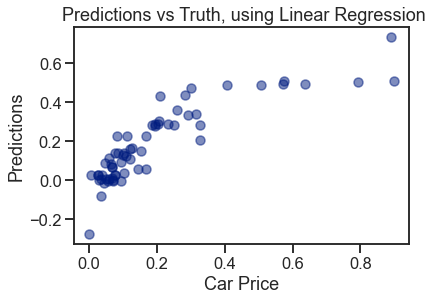

In [492]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred, alpha=.5)

ax.set(xlabel='Car Price', 
       ylabel='Predictions',
       title=' Predictions vs Truth, using Linear Regression')
       

[Text(0.5, 0, 'Car Price'),
 Text(0, 0.5, 'Predictions'),
 Text(0.5, 1.0, 'Predictions vs Truth, using Linear Regression with one hot incoding')]

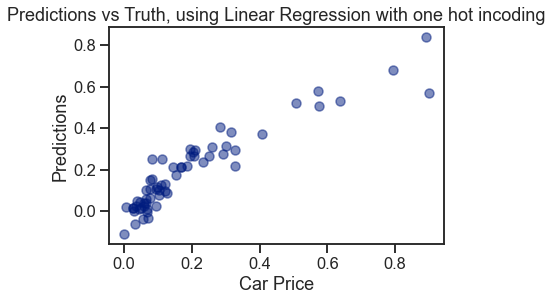

In [493]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test_ohc, y_test_ohc_pred, alpha=.5)

ax.set(xlabel='Car Price', 
       ylabel='Predictions',
       title='Predictions vs Truth, using Linear Regression with one hot incoding')

### One-hot incoding을 적용했을때 보다 더 y=x 형태의 그래프가 나오는 것을 볼 수 있다.
### 여기서 Scaling을 price열에도 적용하여 Price이 0~1사이로 mapping되었지만, 우리는 prediction과 실제 price의 차이가 중요하기때문에 괜찮다.

In [494]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

In [495]:
linearRegression = LinearRegression().fit(X_train_ohc, y_train_ohc)

linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test_ohc))

print(linearRegression_rmse)

0.07500202240841766


[Text(0.5, 0, 'Actual Price'),
 Text(0, 0.5, 'Predicted Price'),
 (0.0, 0.8985899409165385),
 (0.0, 0.8985899409165385),
 Text(0.5, 1.0, 'Linear Regression Results')]

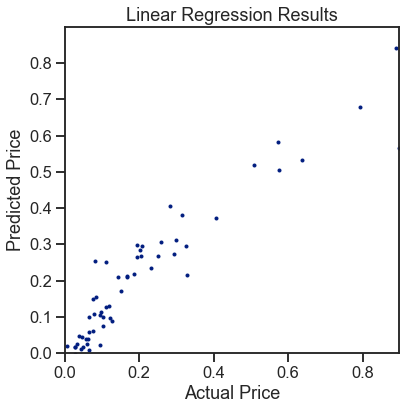

In [496]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test, linearRegression.predict(X_test_ohc), 
         marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results')

In [497]:
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas=alphas, 
                  cv=4).fit(X_train_ohc, y_train_ohc)

ridgeCV_rmse = rmse(y_test_ohc, ridgeCV.predict(X_test_ohc))


y_test_ridgecv_pred=ridgeCV.predict(X_test_ohc)
print(ridgeCV.alpha_, ridgeCV_rmse)


0.3 0.08170512173599308


In [498]:
lassor = Lasso(alpha=0.00001)
lassor = lassor.fit(X_train_ohc, y_train_ohc)
y_train_ls_pred = lassor.predict(X_train_ohc)
y_test_ls_pred= lassor.predict(X_test_ohc)

[Text(0.5, 0, 'Car Price'),
 Text(0, 0.5, 'Predictions'),
 Text(0.5, 1.0, 'Car price prediction vs Truthusing Lasso Regression')]

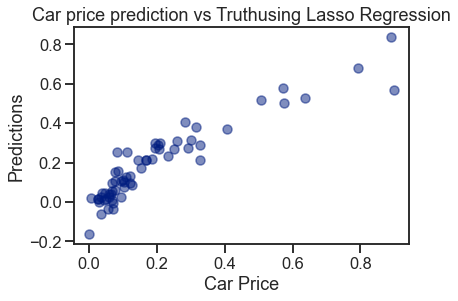

In [499]:
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test_ohc, y_test_ls_pred, alpha=.5)

ax.set(xlabel='Car Price', 
       ylabel='Predictions',
       title='Car price prediction vs Truthusing Lasso Regression')

### One hot incoding 하기 전 결과

In [500]:
print("R2 score :--->>",r2_score(y_test,y_test_pred))
print("MSE :--->>",mean_squared_error(y_test,y_test_pred))
print("RMSE :--->>",rmse(y_test,y_test_pred))

R2 score :--->> 0.7400479031477138
MSE :--->> 0.011099581412087707
RMSE :--->> 0.10535455097947932


### One hot incoding 후 결과

In [501]:
print("R2 score :--->>",r2_score(y_test_ohc,y_test_ohc_pred))
print("MSE :--->>",mean_squared_error(y_test_ohc,y_test_ohc_pred))
print("RMSE :--->>",rmse(y_test_ohc,y_test_ohc_pred))

R2 score :--->> 0.8682554457719289
MSE :--->> 0.005625303365352786
RMSE :--->> 0.07500202240841766


### Ridge CV 결과

In [502]:
print("R2 score :--->>",r2_score(y_test_ohc,y_test_ridgecv_pred))
print("MSE :--->>",mean_squared_error(y_test_ohc,y_test_ridgecv_pred))
print("RMSE :--->>",rmse(y_test_ohc,y_test_ridgecv_pred))

R2 score :--->> 0.8436545356179114
MSE :--->> 0.0066757269178934495
RMSE :--->> 0.08170512173599308


### Lasso Regression 결과

In [503]:
print("R2 score :--->>",r2_score(y_test_ohc,y_test_ls_pred))
print("MSE :--->>",mean_squared_error(y_test_ohc,y_test_ls_pred))
print("RMSE :--->>",rmse(y_test_ohc,y_test_ls_pred))

R2 score :--->> 0.8607112559317739
MSE :--->> 0.0059474294429378745
RMSE :--->> 0.07711957885607179


### SGD 결과

In [504]:
SGD = SGDRegressor(eta0=1e-7, penalty='l1', alpha=0.3)  #위에 ridge alpha값이 0.3이어서
SGD.fit(X_train_ohc, y_train_ohc)
y_test_sgd_pred=SGD.predict(X_test_ohc)
print("R2 score :--->>",-r2_score(y_test_ohc,y_test_sgd_pred))
print("MSE :--->>",mean_squared_error(y_test_ohc,y_test_sgd_pred))
print("RMSE :--->>",rmse(y_test_ohc,y_test_sgd_pred))

R2 score :--->> 0.8904482693162863
MSE :--->> 0.08071942763569936
RMSE :--->> 0.2841116464274201


# Reasoning
## 원래 데이터에 대한 모델 평가:

R2 score(결정 계수)는 0.74로, 모델이 데이터의 분산을 어느 정도 설명한다는 의미입니다.
MSE(평균 제곱 오차)는 0.011로, 예측 오차의 제곱 평균을 의미하며, 낮을수록 모델의 예측이 더 정확함을 나타냅니다.


## 원핫 인코딩 적용 후의 모델 평가:

R2 score가 0.868로 원래 데이터보다 향상되었습니다. 이는 데이터를 더 잘 설명하는 모델임을 시사합니다.
MSE가 0.0056으로 낮아졌으며, 이는 더 작은 예측 오차를 보여줍니다. 더 정확한 예측을 수행하는 것으로 보입니다.
RMSE(평균 제곱근 오차)는 0.075로, 오차의 제곱 평균의 제곱근이므로 원래 데이터에 비해 작아졌다고 볼 수 있습니다.

## Ridge Regression 모델 평가:

R2 score가 0.843으로 적절한 모델 성능을 보입니다. 그러나 원핫 인코딩 결과보다는 낮은 성능을 보입니다.
MSE는 0.0067로 원핫 인코딩 결과보다 크지만, 여전히 비교적 작은 값을 가지고 있습니다.
RMSE가 0.081로, 예측의 정확성 면에서 원핫 인코딩 결과보다 다소 떨어집니다.

## Lasso Regression 모델 평가:

R2 score가 0.861로 좋은 성능을 보입니다. Ridge Regression과 유사한 성능을 보여주고 있습니다.
MSE는 0.0059로, 원핫 인코딩 결과와 유사한 수준으로 낮은 예측 오차를 보여줍니다.
RMSE가 0.077로, 예측 정확성 면에서 원핫 인코딩 결과와 유사합니다.

## SGD 모델 평가:

R2 score가 0.89로 가장 높은 성능을 보입니다. 모든 모델 중에서 가장 데이터를 잘 설명하는 모델로 보입니다.
MSE는 0.0807로 다른 모델들보다는 더 큰 예측 오차를 보여주지만, 여전히 상당히 정확한 예측을 수행합니다.
RMSE가 0.284로, 다른 모델들에 비해 크지만, 이는 모델이 일부 데이터에서 더 큰 오차를 보일 수 있다는 것을 나타냅니다.

### 종합적으로, 먼저 데이터의 개수가 매우 적기 때문에 시간에 관한 유불리함은 이 과제에서 찾아보기 힘들었습니다

### 데이터 전처리 효과:

실험 결과에서 원핫 인코딩을 적용한 모델이 원래 데이터에 비해 더 좋은 결과를 보였습니다. 이는 범주형 변수를 수치형 변수로 변환함으로써 모델이 데이터를 더 잘 이해하고 학습했다는 것을 시사합니다.
따라서, 이러한 변수 전처리 기법은 모델 성능 향상에 긍정적인 영향을 미칠 것으로 예측됩니다.
또한 car_name과 car_ID column을 drop하지 않았을 때 오차가 매우 크게 나타났는데, drop하고 난 후 오차가 매우 줄어들었습니다. 필요없는 feature을 제거하는 과정이 상당히 중요하단 것을 깨달았습니다.

### 모델 성능 비교:
SGD 모델이 가장 높은 R2 score를 보였으며, 다른 지표들에서도 뛰어난 성능을 보였습니다. 이 모델은 다른 회귀 모델들보다 더 정확한 예측을 수행할 것으로 예상됩니다.
Ridge와 Lasso Regression은 유사한 성능을 보였는데, 둘 다 모델 복잡도를 줄이는 데 도움이 되는데, 이는 과적합을 줄일 수 있을 것으로 보입니다.

### SGD 모델의 주의 사항:
SGD 모델은 다른 모델들보다 더 높은 MSE와 RMSE를 보였습니다. 이는 일부 데이터에서 더 큰 오차를 보일 수 있다는 것을 보여줍니다.
따라서, SGD 모델을 적용할 때는 데이터의 특성을 잘 고려하고 추가적인 조정이 필요할 수 있다는 점을 고려해야 합니다